In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from pyhessian import hessian
from torch.utils.data import TensorDataset, DataLoader

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
device = 'mps'

In [4]:
data = pd.read_csv('~/data/MNIST/mnist_train.csv')
test = pd.read_csv('~/data/MNIST/mnist_test.csv')

X = torch.tensor(data.drop('label', axis = 1).to_numpy(), device=device)/255
X_test = torch.tensor(test.drop('label', axis = 1).to_numpy(), device=device)/255

Y_temp = torch.tensor(data['label'].to_numpy(), device=device)
Y = torch.eye(10, device=device)[Y_temp]

Y_temp = torch.tensor(test['label'].to_numpy(), device=device)
Y_test = torch.eye(10, device=device)[Y_temp]

In [5]:
gen = torch.Generator(device=device)
gen.manual_seed(123)

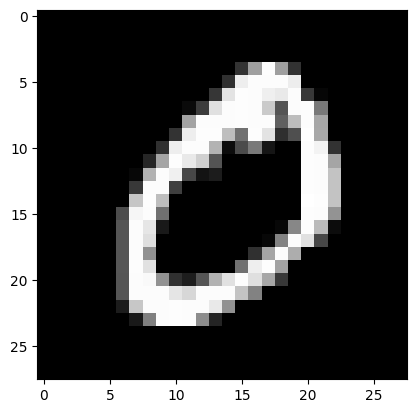

In [6]:
plt.imshow(X[1].view(28,28).cpu(), cmap='gray')

In [7]:
def permut(x, perm = np.random.permutation(X.shape[1])):
    x = x[perm]
    return x

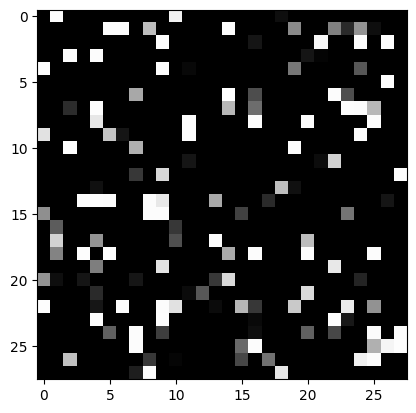

In [8]:
plt.imshow(permut(X[4]).view(28,28).cpu(), cmap='gray')

In [9]:
X_perm = torch.tensor(np.apply_along_axis(permut, axis = 1, arr=X.cpu())).to(device)
X_test_perm = torch.tensor(np.apply_along_axis(permut, axis = 1, arr=X_test.cpu())).to(device)

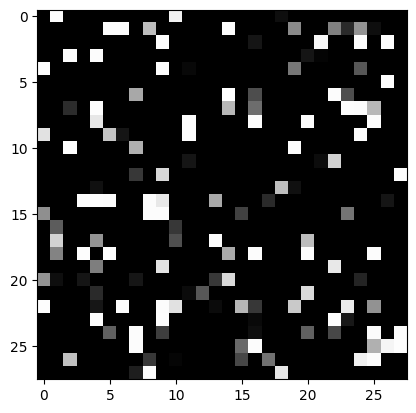

In [10]:
plt.imshow(X_perm[4].cpu().view(28,28), cmap='gray')

In [11]:
from torchsummary import summary

class MLP(nn.Module):
    """Standard MLP"""
    def __init__(self, w, L):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, w)
        self.layers = nn.ModuleList(nn.Linear(w,w) for _ in range(L))
        self.fc2 = nn.Linear(w, 10)
        self.relu = nn.ReLU()
        self.L = L

    def forward(self, x):
        x = self.relu(self.fc1(x))
        for l in self.layers:
            x = self.relu(l(x))
        x = self.fc2(x)

        return x
    
mlp = MLP(128, 2)
summary(mlp, (1,784))
mlp = mlp.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]         100,480
              ReLU-2               [-1, 1, 128]               0
            Linear-3               [-1, 1, 128]          16,512
              ReLU-4               [-1, 1, 128]               0
            Linear-5               [-1, 1, 128]          16,512
              ReLU-6               [-1, 1, 128]               0
            Linear-7                [-1, 1, 10]           1,290
Total params: 134,794
Trainable params: 134,794
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.51
Estimated Total Size (MB): 0.52
----------------------------------------------------------------


In [12]:
optimizer = torch.optim.SGD(mlp.parameters(), lr=2/4)

In [13]:
def top_eigen(model, loss, X, Y, prt=False):

    hess_comp = hessian(model, loss, (X,Y) )
    top_eigenvalues, top_eigenvector = hess_comp.eigenvalues()
        
    return top_eigenvalues[-1] , top_eigenvector

In [14]:
MSE = nn.MSELoss()

s, e = top_eigen(mlp, MSE , X, Y)
print(s)

/opt/homebrew/lib/python3.11/site-packages/torch/autograd/graph.py:690: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/engine.cpp:1183.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


0.38695311546325684


In [15]:
def GSalign(model, eigen):
   z = 0
   for g,p in zip(model.parameters(), eigen[0]):
        if g.requires_grad:
          gd = g.grad
          z += torch.sum(gd*p)/(torch.sqrt(torch.sum(gd*gd))*torch.sqrt(torch.sum(p*p))*len(eigen[0]))

   return z.item()

In [16]:
loss_hist = []
lam = []
all = []
batch = len(X)

for epoch in range(350):

        running_loss = 0.0
        for i in range(len(X)//batch):

            # Batch of training 
            ix = torch.randint(0, len(X), (batch,), generator=gen, device=device)

            ixc = torch.randint(0, len(X), (2048,), generator=gen, device=device)
            sharp, eigen = top_eigen(mlp, MSE, X[ixc], Y[ixc])

            optimizer.zero_grad()

            out = mlp(X[ix])
            loss = MSE(out, Y[ix])
            loss.backward()
            running_loss += loss.item()

            all.append(GSalign(mlp,eigen))

            optimizer.step()

            lam.append(sharp)
            loss_hist.append(loss.item())

            print(f'(epoch: {epoch}), sample: {batch*(i+1)}, ---> train loss = {loss.item():.4f} -----> sharpness = {sharp:.3f}')

            if epoch == 349:
                  sharp, eigen = top_eigen(mlp, MSE, X[ixc], Y[ixc])
                  task1_eigen = eigen
                  

print('Finished Training')

acc = []
acc.append( torch.sum(torch.argmax(mlp(X_test), dim=1) == torch.argmax(Y_test, dim=1))/len(Y_test) )

(epoch: 0), sample: 60000, ---> train loss = 0.1026 -----> sharpness = 0.384
(epoch: 1), sample: 60000, ---> train loss = 0.0988 -----> sharpness = 0.373
(epoch: 2), sample: 60000, ---> train loss = 0.0961 -----> sharpness = 0.371
(epoch: 3), sample: 60000, ---> train loss = 0.0941 -----> sharpness = 0.367
(epoch: 4), sample: 60000, ---> train loss = 0.0927 -----> sharpness = 0.366
(epoch: 5), sample: 60000, ---> train loss = 0.0917 -----> sharpness = 0.371
(epoch: 6), sample: 60000, ---> train loss = 0.0909 -----> sharpness = 0.375
(epoch: 7), sample: 60000, ---> train loss = 0.0904 -----> sharpness = 0.379
(epoch: 8), sample: 60000, ---> train loss = 0.0900 -----> sharpness = 0.378
(epoch: 9), sample: 60000, ---> train loss = 0.0897 -----> sharpness = 0.383
(epoch: 10), sample: 60000, ---> train loss = 0.0894 -----> sharpness = 0.389
(epoch: 11), sample: 60000, ---> train loss = 0.0892 -----> sharpness = 0.394
(epoch: 12), sample: 60000, ---> train loss = 0.0890 -----> sharpness = 0.

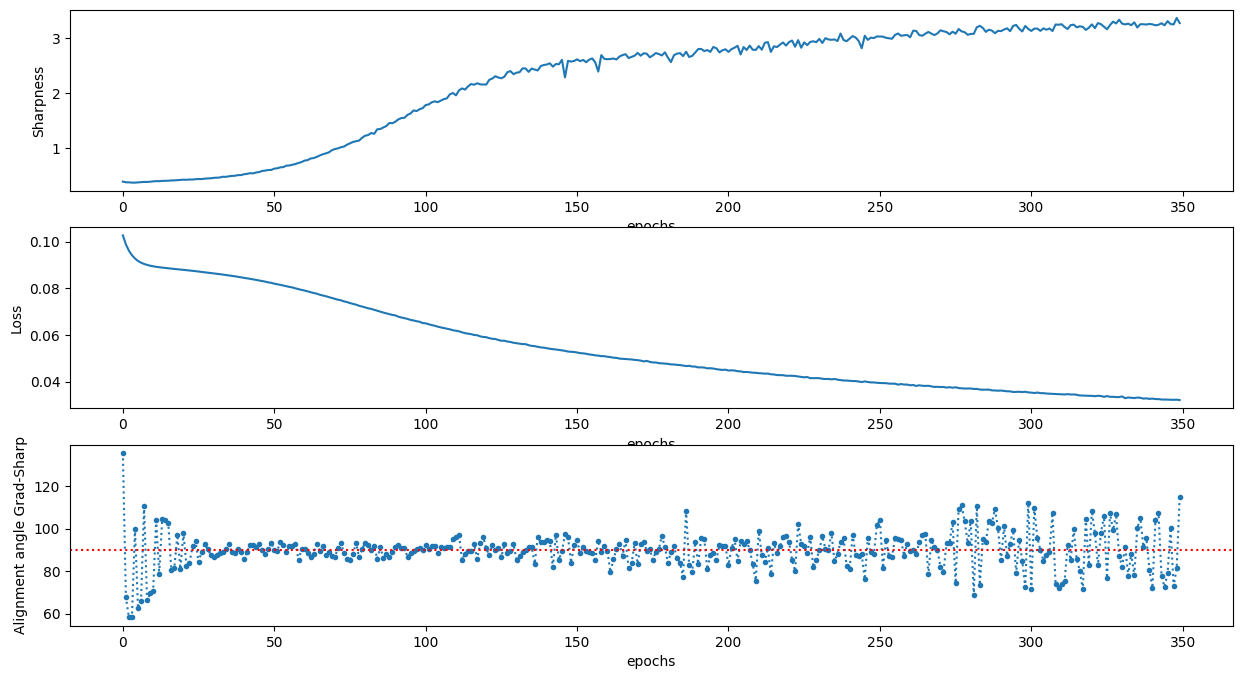

In [17]:
fig, ax = plt.subplots(3,1, figsize=(15,8))

ax[0].plot(lam)
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Sharpness')

ax[1].plot(loss_hist)
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('Loss')

ax[2].plot(np.arccos(all)*180/np.pi, linestyle=':', marker='.')
ax[2].set_xlabel('epochs')
ax[2].set_ylabel('Alignment angle Grad-Sharp')
ax[2].axhline(90, color='r', linestyle='dotted')
plt.show()

In [18]:
acc = []
acc.append( torch.sum(torch.argmax(mlp(X_test), dim=1) == torch.argmax(Y_test, dim=1))/len(Y_test) )

In [19]:
acc

[tensor(0.8799, device='mps:0')]

In [20]:
hess_comp = hessian( mlp, MSE, (X,Y) )
top_eigenvalues, top_eigenvector = hess_comp.eigenvalues()

print("The top Hessian eigenvalue of this model is %.4f"%top_eigenvalues[0])

The top Hessian eigenvalue of this model is 3.2704


In [21]:
hess_comp = hessian(mlp, MSE, (X_perm,Y) )
top_eigenvalues, top_eigenvector = hess_comp.eigenvalues()
print("The top Hessian eigenvalue of this model is %.4f", top_eigenvalues[0])

The top Hessian eigenvalue of this model is %.4f 2.142747163772583


In [22]:
optimizer = torch.optim.SGD(mlp.parameters(), lr=2/4)

old_loss = []
batch = len(X)

In [23]:
for epoch in range(350):

        running_loss = 0.0
        for i in range(len(X)//batch):

            # Batch of training 
            ix = torch.randint(0, len(X), (batch,), generator=gen, device=device)

            ixc = torch.randint(0, len(X), (2048,), generator=gen, device=device)
            sharp, eigen = top_eigen(mlp, MSE, X[ixc], Y[ixc])

            optimizer.zero_grad()
 
            out = mlp(X_perm[ix])
            loss = MSE(out, Y[ix])
            loss.backward()
            running_loss += loss.item()

            all.append(GSalign(mlp,eigen))

            optimizer.step()

            lam.append(sharp)
            loss_hist.append(loss.item())
            old_loss.append( MSE( mlp(X[ix]) , Y[ix]).item() )

            print(f'(epoch: {epoch}), sample: {batch*(i+1)}, ---> train loss = {loss.item():.4f} -----> sharpness = {sharp:.3f}')

print('Finished Training')

acc.append( torch.sum(torch.argmax(mlp(X_test), dim=1) == torch.argmax(Y_test, dim=1))/len(Y_test) )

(epoch: 0), sample: 60000, ---> train loss = 0.0918 -----> sharpness = 3.338
(epoch: 1), sample: 60000, ---> train loss = 0.0865 -----> sharpness = 3.387
(epoch: 2), sample: 60000, ---> train loss = 0.0837 -----> sharpness = 3.427
(epoch: 3), sample: 60000, ---> train loss = 0.0813 -----> sharpness = 3.413
(epoch: 4), sample: 60000, ---> train loss = 0.0791 -----> sharpness = 3.391
(epoch: 5), sample: 60000, ---> train loss = 0.0770 -----> sharpness = 3.393
(epoch: 6), sample: 60000, ---> train loss = 0.0751 -----> sharpness = 3.545
(epoch: 7), sample: 60000, ---> train loss = 0.0731 -----> sharpness = 3.425
(epoch: 8), sample: 60000, ---> train loss = 0.0711 -----> sharpness = 3.439
(epoch: 9), sample: 60000, ---> train loss = 0.0696 -----> sharpness = 3.512
(epoch: 10), sample: 60000, ---> train loss = 0.0678 -----> sharpness = 3.504
(epoch: 11), sample: 60000, ---> train loss = 0.0663 -----> sharpness = 3.606
(epoch: 12), sample: 60000, ---> train loss = 0.0648 -----> sharpness = 3.

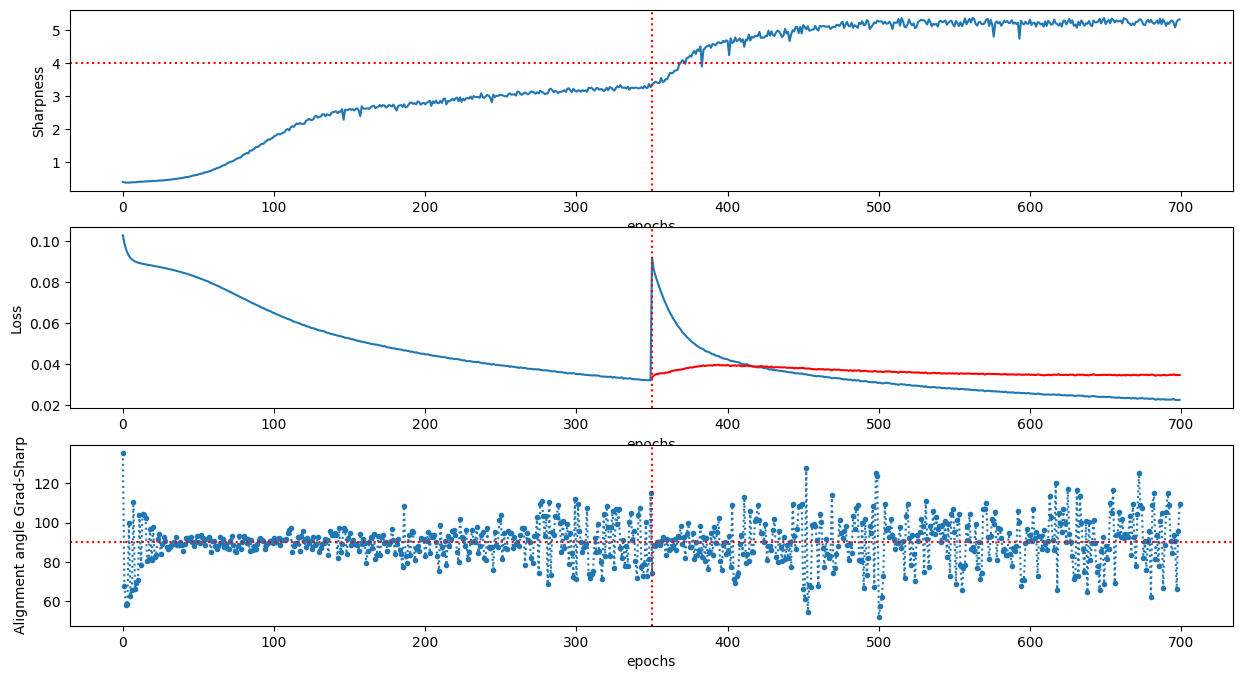

In [24]:
fig, ax = plt.subplots(3,1, figsize=(15,8))

ax[0].plot(lam)
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Sharpness')
ax[0].axvline(350, color='r', linestyle='dotted')
ax[0].axhline(4, color='r', linestyle='dotted')


ax[1].plot(loss_hist)
ax[1].plot(np.arange(350,700,1),old_loss, color='red')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('Loss')
ax[1].axvline(350, color='r', linestyle='dotted')

ax[2].plot(np.arccos(all)*180/np.pi, linestyle=':', marker='.')
ax[2].set_xlabel('epochs')
ax[2].set_ylabel('Alignment angle Grad-Sharp')
ax[2].axvline(350, color='r', linestyle='dotted')
ax[2].axhline(90, color='r', linestyle='dotted')
plt.show()


In [25]:
torch.sum(torch.argmax(mlp(X_test_perm), dim=1) == torch.argmax(Y_test, dim=1))/len(Y_test)

tensor(0.9080, device='mps:0')

In [26]:
acc

[tensor(0.8799, device='mps:0'), tensor(0.8493, device='mps:0')]

In [27]:
counts, bins = torch.histogram(torch.tensor(all[:350]), 50)
counts1, bins1 = torch.histogram(torch.tensor(all[350:]), 50)

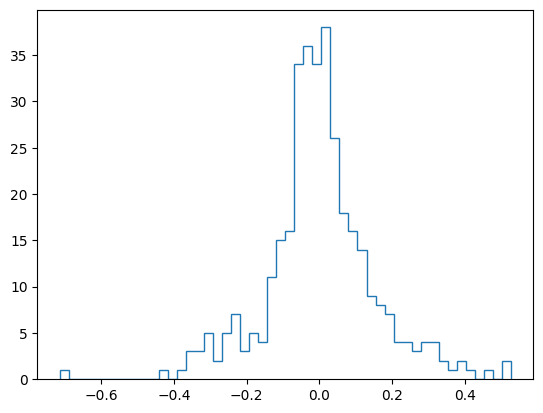

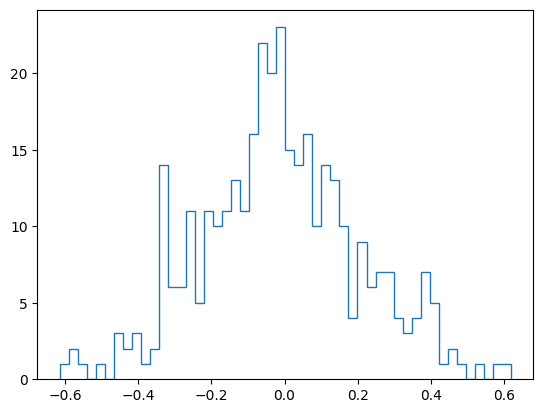

In [28]:
plt.stairs(counts, bins)
plt.show()
plt.stairs(counts1, bins1)
plt.show()